# Deep Dynamic Network

## Define model and function to add noise to input

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model

In [ ]:
# Check if TensorFlow detects a GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
# Function to generate random noise
def generate_noise(num_noise_inputs):
    return np.random.rand(num_noise_inputs)  # Random values between 0 and 1 for noise

# Define the Frozen Lake environment
states = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
num_states = len(states)
num_actions = 4

# Define the transition matrix
R = np.array([
    ['A', 'E', 'B', 'A'],
    ['B', 'F', 'C', 'A'],
    ['C', 'G', 'D', 'B'],
    ['D', 'H', 'D', 'C'],
    ['A', 'I', 'F', 'E'],
    ['B', 'J', 'G', 'E'],
    ['C', 'K', 'H', 'F'],
    ['D', 'L', 'H', 'G'],
    ['E', 'M', 'J', 'I'],
    ['F', 'N', 'K', 'I'],
    ['G', 'O', 'L', 'J'],
    ['H', 'P', 'L', 'K'],
    ['I', 'M', 'N', 'M'],
    ['J', 'N', 'O', 'M'],
    ['K', 'O', 'P', 'N'],
    ['L', 'P', 'P', 'O']
])
listOfHoles = np.array(['F', 'H', 'L', 'M'])

# Convert states to one-hot encoded vectors, ie: state A: (1, 0, 0, 0, 0, ... 0)
def state_to_one_hot(state):
    one_hot = np.zeros(num_states)
    one_hot[states.index(state)] = 1
    return one_hot

In [ ]:
# Define the number of noise inputs
num_noise_inputs = 20  # additional noise inputs
total_inputs = num_states + num_noise_inputs  # Total input size (original inputs + noise)

# Define the model that accepts both state input and noise input
model = tf.keras.Sequential([
    layers.Input(shape=(total_inputs,)),  # Input size is 36 (16 original + 10 random)
    layers.Dense(32, activation='tanh'),
    layers.Dense(32, activation='tanh'),
    layers.Dense(32, activation='tanh'),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')

## Trained model with noisy input

In [ ]:
import time  # Import the time module

In [ ]:
# Hyperparameters
gamma = 0.9
epsilon = 0.9
evaluation_interval = 2  # Evaluate every iterations

In [ ]:
def evaluate_vin_policy_with_noise(vin_model, noise_size=20, epsilon=0.9, max_steps=100):
    total_reward = 0
    time_steps = 0
    current_state = states[0]  # Start from the initial state

    while time_steps < max_steps:
        state_index = states.index(current_state)
        state_vector = state_to_one_hot(current_state)

        # Generate and append noise to the state vector
        noise_vector = generate_noise(noise_size)
        noisy_state_vector = np.concatenate([state_vector, noise_vector])

        # Predict the values for all possible actions with noise added
        action_values = []

        # Choose an action using epsilon-greedy policy
        if np.random.rand() < epsilon:
            # Exploration: Choose a random action
            best_action = np.random.randint(0, len(R[state_index]))
        else:
          for action in range(len(R[state_index])):
            next_state = R[state_index][action]

            # Generate noise for the next state and append
            next_noise_vector = generate_noise(noise_size)
            next_state_vector = np.concatenate([state_to_one_hot(next_state), next_noise_vector])
            # Predict the value of the next state using the VIN model
            next_state_value = vin_model.predict(next_state_vector.reshape(1, -1))[0][0]
            action_values.append(next_state_value)

          # Exploitation: Choose the best action based on predicted values
          best_action = np.argmax(action_values)

        # Update the current state and calculate reward
        next_state = R[state_index][best_action]
        reward = 0
        if next_state == 'P':
            reward = 1
        elif next_state in listOfHoles:
            reward = -10

        total_reward += reward
        time_steps += 1

        # Check if we've reached a terminal state
        if next_state == 'P':
            break

        # Update current state
        current_state = next_state

    return total_reward, time_steps


In [ ]:
import time
import numpy as np

# Store reward history for plotting or analysis
reward_history = []
time_steps_history = []

#start_time = time.time()  # Record the start time

import numpy as np
import random

# Start timer
start_time = time.time()

# Training loop with evaluation every iterations
for iteration in range(200):
    for state in states:
        state_index = states.index(state)
        state_vector = state_to_one_hot(state)

        # Generate random noise and concatenate to the state vector
        noise_vector = generate_noise(num_noise_inputs)
        noisy_state_vector = np.concatenate([state_vector, noise_vector])

        # Next state vectors for all actions with noise
        next_state_vectors = np.array([
            np.concatenate([state_to_one_hot(R[state_index][a]), generate_noise(num_noise_inputs)])
            for a in range(num_actions)
        ])

        # Predict the values of all possible next states (with noisy inputs)
        next_state_values = model.predict(next_state_vectors)

        # Calculate the target value using the Bellman equation
        target_value = -float('inf')
        for a in range(num_actions):
            next_state = R[state_index][a]

            # Reward calculation
            reward = 0
            if state == 'P':
                reward = 1
            if state in listOfHoles:
                reward = -10

            # Calculate the target value for each action
            value = reward + gamma * next_state_values[a]
            target_value = max(target_value, value)

        # Train the model to output the target value for the current state (with noisy input)
        model.fit(noisy_state_vector.reshape(1, -1), np.array([target_value]), epochs=1, verbose=0)

    # Evaluate the policy every few iterations
    if iteration % evaluation_interval == 0:
      policy_reward, policy_time_steps = evaluate_vin_policy_with_noise(model, noise_size=num_noise_inputs, epsilon=epsilon)
      reward_history.append(policy_reward)
      time_steps_history.append(policy_time_steps)  # Store the time steps for this evaluation
      #print(f"Iteration {iteration}: Evaluated reward = {policy_reward}, Time steps = {policy_time_steps}")

      epsilon = max(0.01, epsilon * 0.995)

# End timer
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

In [ ]:
print(f"Training completed in {elapsed_time:.2f} seconds.")

Training completed in 953.25 seconds.


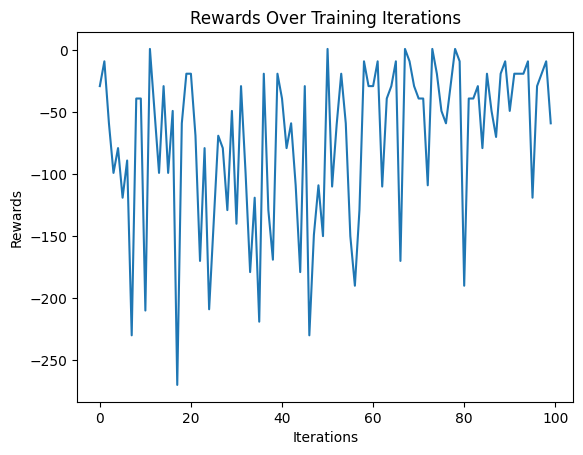

In [ ]:
import matplotlib.pyplot as plt

# Assume reward_history contains the rewards at intervals
evaluation_intervals = range(0, 200, evaluation_interval)

# Plot the rewards over the training iterations
plt.plot(reward_history)

# Add labels and title to the plot
plt.xlabel('Iterations')
plt.ylabel('Rewards')
plt.title('Rewards Over Training Iterations')

# Optional: Display the grid
#plt.grid(True)

# Show the plot
plt.show()

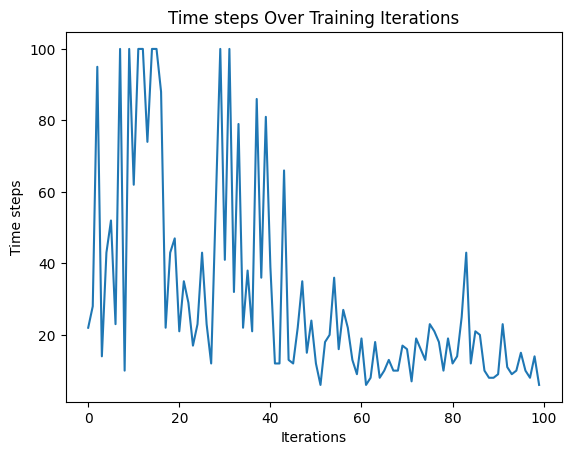

In [ ]:
# Assume reward_history contains the rewards at intervals
evaluation_intervals2 = range(0, 100, evaluation_interval)

# Plot the rewards over the training iterations
plt.plot(time_steps_history)

# Add labels and title to the plot
plt.xlabel('Iterations')
plt.ylabel('Time steps')
plt.title('Time steps Over Training Iterations')

# Optional: Display the grid
#plt.grid(True)

# Show the plot
plt.show()

In [ ]:
# After training, print out the state values for all states
print("\nFinal State Values After Training:")
for state in states:
    state_vector = state_to_one_hot(state)
    noise_vector = np.random.random(num_noise_inputs)  # Add the same 20-dimensional noise vector
    noisy_state_vector = np.concatenate([state_vector, noise_vector])

    # Predict the value for the noisy state
    state_value = model.predict(noisy_state_vector.reshape(1, -1), verbose=0)

    print(f"State: {state}, Value: {state_value[0][0]}")


Final State Values After Training:
State: A, Value: 2.760903835296631
State: B, Value: 2.8240914344787598
State: C, Value: 2.359358549118042
State: D, Value: 2.3954596519470215
State: E, Value: 2.6964755058288574
State: F, Value: -6.708893775939941
State: G, Value: 3.9591071605682373
State: H, Value: -6.815040588378906
State: I, Value: 2.7434332370758057
State: J, Value: 2.4136650562286377
State: K, Value: 3.0824780464172363
State: L, Value: -6.500688076019287
State: M, Value: -6.315786361694336
State: N, Value: 3.3008956909179688
State: O, Value: 4.044515609741211
State: P, Value: 5.618696689605713


## Testing


In [ ]:
e = 0.9
reward_history_test = []
time_steps_history_test = []
for iteration in range(200):
  policy_reward, policy_time_steps = evaluate_vin_policy_with_noise(model, noise_size=num_noise_inputs, epsilon=e)
  reward_history_test.append(policy_reward)
  time_steps_history_test.append(policy_time_steps)  # Store the time steps for this evaluation
  print(f"Iteration {iteration}: Evaluated reward = {policy_reward}, Time steps = {policy_time_steps}")

  e = max(0.01, e * 0.995)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Iteration 0: Evaluated reward = -69, Time steps = 30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Iteration 1: Evaluated reward = -29, Time steps = 14
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━

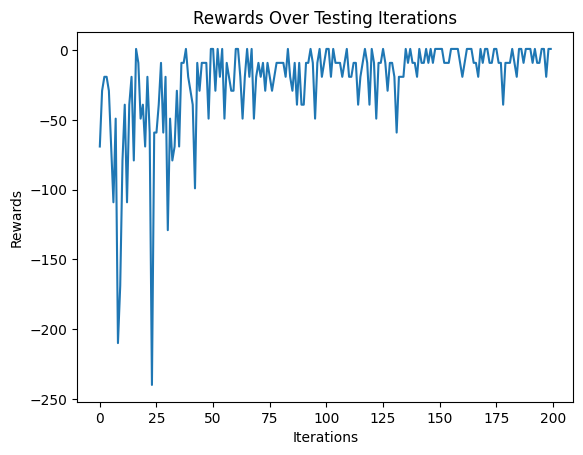

In [ ]:
import matplotlib.pyplot as plt

# Assume reward_history contains the rewards at intervals
evaluation_intervals = range(0, 200, evaluation_interval)

# Plot the rewards over the training iterations
plt.plot(reward_history_test)

# Add labels and title to the plot
plt.xlabel('Iterations')
plt.ylabel('Rewards')
plt.title('Rewards Over Testing Iterations')

# Optional: Display the grid
#plt.grid(True)

# Show the plot
plt.show()

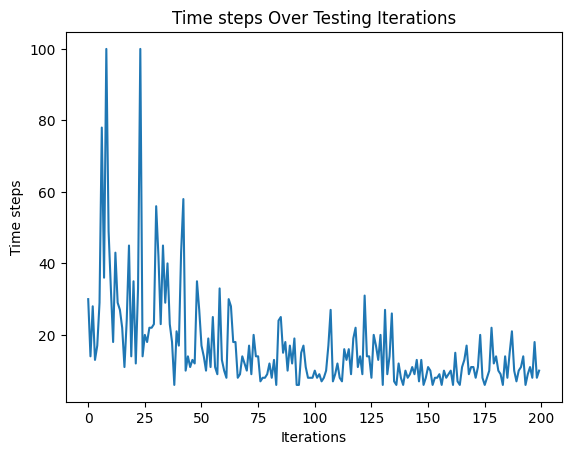

In [ ]:
# Assume reward_history contains the rewards at intervals
evaluation_intervals2 = range(0, 200, evaluation_interval)

# Plot the rewards over the training iterations
plt.plot(time_steps_history_test)

# Add labels and title to the plot
plt.xlabel('Iterations')
plt.ylabel('Time steps')
plt.title('Time steps Over Testing Iterations')

# Optional: Display the grid
#plt.grid(True)

# Show the plot
plt.show()

# Reduced Network: Use the activations of the first hidden layer as input

In [ ]:
# Step 1: Freeze the layers of the original model
for layer in model.layers:
    layer.trainable = False

In [ ]:
for layer in model.layers:
    print(layer.name)

dense
dense_1
dense_2
dense_3
dense_4
dense_5


In [ ]:
# Assuming your original model structure is something like this:
#input_layer = layers.Input(shape=(total_inputs,))
first_hidden_layer_output = model.get_layer('dense_2').output

# Create the feature extraction model

feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=first_hidden_layer_output)
# Create dummy data
dummy_input = np.random.random((1, 36))

# Predict features using the feature extractor
try:
    features = feature_extractor.predict(dummy_input)
    print("Feature extraction successful. Output shape:", features.shape)
except Exception as e:
    print("Error during feature extraction:", str(e))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Feature extraction successful. Output shape: (1, 32)


In [ ]:
# Extract features for each state after training
state_features_dict = {}
print("\nExtracted Features for Each State:")

for state in states:
    # One-hot encode the state and add noise
    state_vector = state_to_one_hot(state)
    noise_vector = np.random.random(num_noise_inputs)
    noisy_state_vector = np.concatenate([state_vector, noise_vector])

    # Use the feature extractor model to get the features
    extracted_features = feature_extractor.predict(noisy_state_vector.reshape(1, -1), verbose=0)
    state_features_dict[state] = extracted_features.reshape(-1)

    #print(f"State: {state}, Extracted Features:\n {extracted_features}")


Extracted Features for Each State:


In [ ]:
# convert to 0 & 1
for state, features in state_features_dict.items():
    state_features_dict[state] = np.where(features > 0, 1, 0)

In [ ]:
for state in states:
    print(state_features_dict[state])

[1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 0 0 0 0 0 1 1 0 1 1]
[0 0 1 0 1 0 0 1 1 0 0 1 1 1 1 0 0 0 0 1 1 0 0 0 0 0 0 1 1 1 1 1]
[0 1 1 0 1 0 1 1 1 1 1 1 0 0 1 0 1 0 0 1 0 1 0 1 0 1 1 1 1 1 0 0]
[0 1 0 0 0 1 0 1 0 0 0 1 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 0]
[0 0 1 0 1 0 0 1 0 1 0 1 1 1 1 0 1 0 1 1 1 1 0 0 0 1 0 1 1 1 1 1]
[0 1 0 0 1 0 1 1 1 0 1 1 0 0 1 0 1 1 1 1 1 0 0 0 0 1 0 1 0 0 1 1]
[0 0 1 0 0 0 0 1 1 1 1 0 0 0 1 0 0 0 1 1 1 1 0 1 0 1 0 1 0 1 0 1]
[0 1 1 0 1 0 1 1 1 0 1 1 0 0 1 0 1 1 1 1 0 0 0 0 0 1 0 1 0 0 1 0]
[1 1 1 0 0 0 0 1 0 1 0 0 1 1 1 0 1 0 1 1 1 1 0 1 0 0 1 0 1 1 1 1]
[0 1 1 0 0 0 0 1 0 1 0 0 1 1 1 0 1 0 0 1 1 1 0 1 0 1 0 1 1 1 1 1]
[1 0 1 0 1 0 0 1 1 1 0 0 1 1 1 0 0 0 1 1 1 0 0 1 0 0 0 1 1 0 1 1]
[0 1 0 0 1 0 0 1 1 0 0 0 1 0 1 0 1 1 1 0 0 1 0 1 0 1 0 0 0 0 1 0]
[0 1 0 1 1 0 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 1 0 0 0 1 0 0 1 0 1 0]
[0 0 1 1 0 0 0 1 0 1 0 0 1 1 1 0 0 0 0 0 1 1 0 0 0 1 1 1 1 1 1 1]
[0 0 0 0 0 0 1 1 1 0 0 1 1 0 1 0 1 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1]
[0 1 0 0 1

# A reduced network locking 3 hidden layers

In [ ]:
# Define a new model using the extracted features
new_model_3 = tf.keras.Sequential([
    layers.Input(shape=(32,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

new_model_3.compile(optimizer='adam', loss='mse')

In [ ]:
def evaluate_vin_policy_with_noise_fe(vin_model, noise_size=10, epsilon=0.9, max_steps=100):
    total_reward = 0
    time_steps = 0
    current_state = states[0]  # Start from the initial state

    while time_steps < max_steps:
        state_index = states.index(current_state)
        #state_features = state_features_dict[state].reshape(1, -1)  # Ensure correct shape

        # Predict the values for all possible actions with noise added
        #action_values = []

        # Generate features for all possible next states based on actions
        next_state_features = np.array([state_features_dict[R[state_index][a]].reshape(1, -1) for a in range(num_actions)])
        next_state_features = np.vstack(next_state_features)  # Stack to shape (num_actions, feature_size)

        # Choose an action using epsilon-greedy policy
        if np.random.rand() < epsilon:
            # Exploration: Choose a random action
            best_action = np.random.randint(0, len(R[state_index]))
        else:
            # Exploitation: Choose the best action based on predicted values
            # Calculate the action value
            next_state_values = vin_model.predict(next_state_features)
            best_action = np.argmax(next_state_values)

        # Update the current state and calculate reward
        next_state = R[state_index][best_action]

        # Calculate reward
        reward = 0
        if next_state == 'P':
            reward = 1
        elif next_state in listOfHoles:
            reward = -10

        total_reward += reward
        time_steps += 1

        # Check if we've reached a terminal state
        if next_state == 'P':
            break

        # Update current state
        current_state = next_state

    return total_reward, time_steps


In [ ]:
# Training loop
# Store reward history for plotting or analysis
reward_history2 = []
start_time2 = time.time()  # Record the start time

# Initial parameters
e = 0.9  # Starting value for epsilon
epsilon_decay = 0.995  # Decay rate for epsilon
min_epsilon = 0.01  # Minimum value for epsilon to avoid full exploitation

time_steps_history2 = []
# Start timer
start_time2 = time.time()

for iteration in range(200):
    for state in states:
        state_index = states.index(state)
        state_features = state_features_dict[state].reshape(1, -1)  # Ensure correct shape

        # Predict the values of all possible next states
        next_state_features = np.array([state_features_dict[R[state_index][a]].reshape(1, -1) for a in range(num_actions)])
        next_state_features = np.vstack(next_state_features)  # Stack to shape (num_actions, 32)

        next_state_values = new_model_3.predict(next_state_features)

        # Calculate the target value using the Bellman equation
        target_value = -float('inf')
        for a in range(num_actions):
            next_state = R[state_index][a]

            # Reward calculation
            reward = 0
            if state == 'P':
                reward = 1
            if state in listOfHoles:
                reward = -10

            # Calculate the target value for each action
            value = reward + gamma * next_state_values[a]
            target_value = max(target_value, value)

        # Train the new model to output target value for the current state
        new_model_3.fit(state_features, np.array([target_value]), epochs=1, verbose=0)

        # Evaluate the policy every 2 iterations
    if iteration % evaluation_interval == 0:
        # Evaluate the policy with the current epsilon
        policy_reward2, policy_time_steps2 = evaluate_vin_policy_with_noise_fe(new_model_3, noise_size=num_noise_inputs, epsilon=e)

        # Record the reward and time steps
        reward_history2.append(policy_reward2)
        time_steps_history2.append(policy_time_steps2)

        # Decay epsilon, ensuring it doesn't go below the min_epsilon
        e = max(min_epsilon, e * epsilon_decay)

end_time2 = time.time()
elapsed_time2 = end_time2 - start_time2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━

In [ ]:
print(f"Training completed in {elapsed_time2:.2f} seconds.")

Training completed in 478.95 seconds.


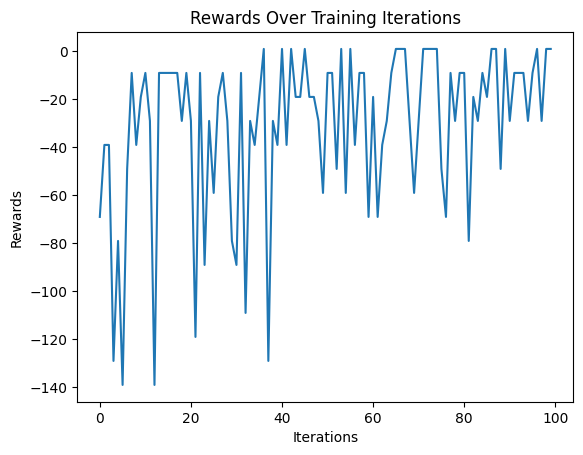

In [ ]:
# Plot the rewards over the training iterations
plt.plot(reward_history2)

# Add labels and title to the plot
plt.xlabel('Iterations')
plt.ylabel('Rewards')
plt.title('Rewards Over Training Iterations')

# Optional: Display the grid
#plt.grid(True)

# Show the plot
plt.show()

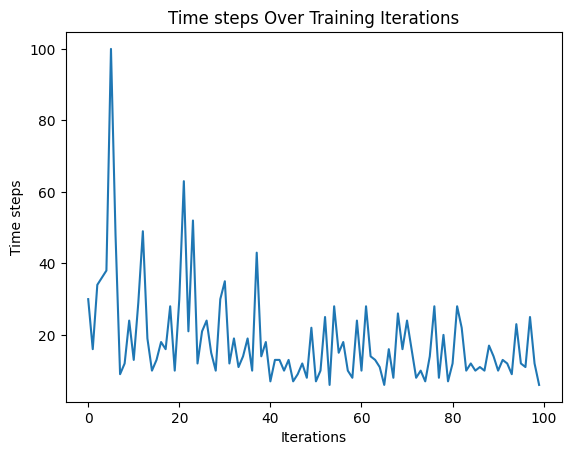

In [ ]:
# Plot the rewards over the training iterations
plt.plot(time_steps_history2)

# Add labels and title to the plot
plt.xlabel('Iterations')
plt.ylabel('Time steps')
plt.title('Time steps Over Training Iterations')

# Optional: Display the grid
#plt.grid(True)

# Show the plot
plt.show()

## State value

In [ ]:
# Predict V values for all states
v_values = {}
for state, features in state_features_dict.items():
    features_reshaped = features.reshape(1, -1)  # Ensure correct shape
    v_value = new_model_3.predict(features_reshaped)
    v_values[state] = v_value[0][0]  # Extract the scalar value

# Print V values for each state
for state in states:
    print(f"State: {state}, V-value: {v_values[state]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
State: A, V-value: 5.733390808105469
State: B, V-value: 6.1644463539123535
State: C, V-value: 6.812761306762695
State: D, V-value: 6.119040012359619
State: E, V-value: 6.095023155212402
State: F, V-value: -3.0727694034576416
State: G, V-value: 7.51608943939209
State: H, V-value: -3.0864908695220947
State: I, V-value: 6.8655219078063965
State: J, V-value: 7.51608943939209
State: K, V-value

## Testing


In [ ]:
e = 0.9
reward_history_test2 = []
time_steps_history_test2 = []
for iteration in range(200):
  policy_reward, policy_time_steps = evaluate_vin_policy_with_noise_fe(new_model_3, noise_size=num_noise_inputs, epsilon=e)
  reward_history_test2.append(policy_reward)
  time_steps_history_test2.append(policy_time_steps)  # Store the time steps for this evaluation
  #print(f"Iteration {iteration}: Evaluated reward = {policy_reward}, Time steps = {policy_time_steps}")

  e = max(0.01, e * 0.995)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

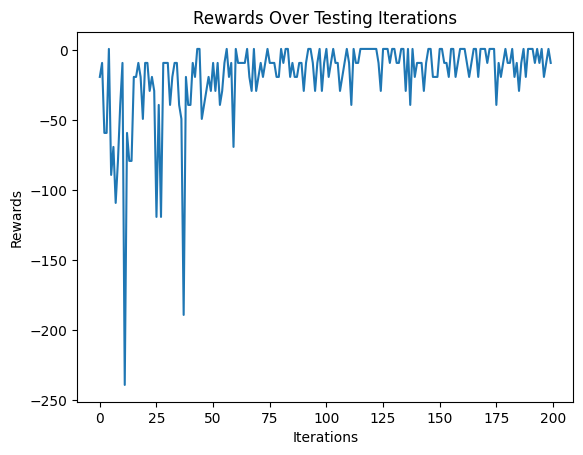

In [ ]:
import matplotlib.pyplot as plt

# Assume reward_history contains the rewards at intervals
evaluation_intervals = range(0, 200, evaluation_interval)

# Plot the rewards over the training iterations
plt.plot(reward_history_test2)

# Add labels and title to the plot
plt.xlabel('Iterations')
plt.ylabel('Rewards')
plt.title('Rewards Over Testing Iterations')

# Optional: Display the grid
#plt.grid(True)

# Show the plot
plt.show()

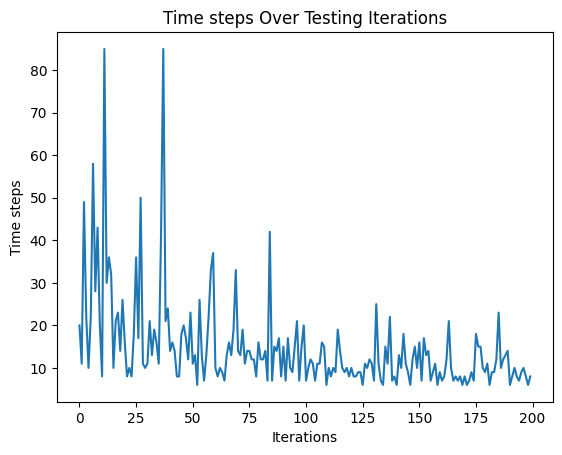

In [ ]:
# Assume reward_history contains the rewards at intervals
evaluation_intervals2 = range(0, 200, evaluation_interval)

# Plot the rewards over the training iterations
plt.plot(time_steps_history_test2)

# Add labels and title to the plot
plt.xlabel('Iterations')
plt.ylabel('Time steps')
plt.title('Time steps Over Testing Iterations')

# Optional: Display the grid
#plt.grid(True)

# Show the plot
plt.show()

# Smooth graphs

## Training

In [ ]:
def moving_average(data, window_size):
    smoothed = []
    for i in range(len(data)):
        smoothed.append(np.mean(data[max(0, i-window_size+1):i+1]))
    return smoothed

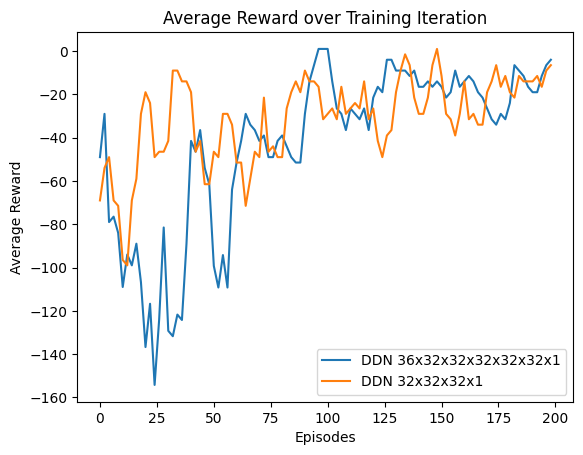

In [ ]:
window_sized = 4

smoothed_rewards = moving_average(reward_history, window_sized)
smoothed_rewards2 = moving_average(reward_history2, window_sized)

# Plot the comparison
plt.plot(range(0, 200, evaluation_interval), smoothed_rewards, label='DDN 36x32x32x32x32x32x1')
plt.plot(range(0, 200, evaluation_interval), smoothed_rewards2, label='DDN 32x32x32x1')
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward over Training Iteration')
plt.legend()
plt.show()

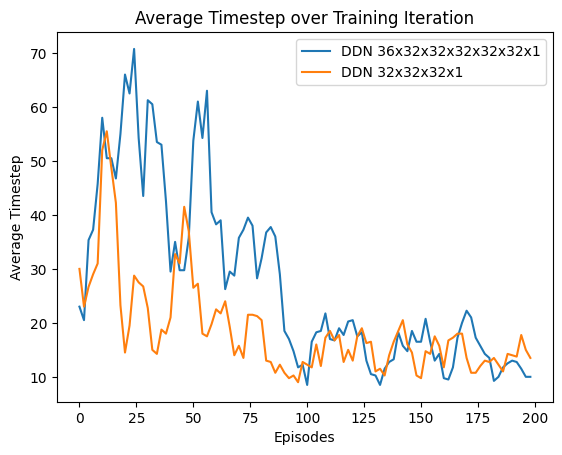

In [ ]:
window_sized = 4

smoothed_timestep = moving_average(time_steps_history, window_sized)
smoothed_timestep2 = moving_average(time_steps_history2, window_sized)

# Plot the comparison
plt.plot(range(0, 200, evaluation_interval), smoothed_timestep, label='DDN 36x32x32x32x32x32x1')
plt.plot(range(0, 200, evaluation_interval), smoothed_timestep2, label='DDN 32x32x32x1')
plt.xlabel('Episodes')
plt.ylabel('Average Timestep')
plt.title('Average Timestep over Training Iteration')
plt.legend()
plt.show()

## Testing

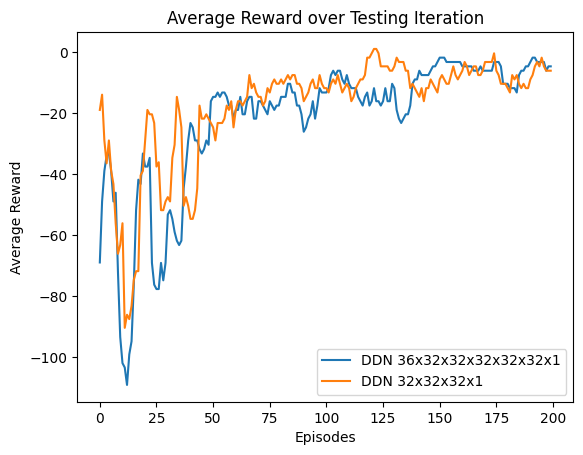

In [ ]:
window_sized = 7

smoothed_rewards_test = moving_average(reward_history_test, window_sized)
smoothed_rewards2_test = moving_average(reward_history_test2, window_sized)

# Plot the comparison
plt.plot(smoothed_rewards_test, label='DDN 36x32x32x32x32x32x1')
plt.plot(smoothed_rewards2_test, label='DDN 32x32x32x1')
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward over Testing Iteration')
plt.legend()
plt.show()

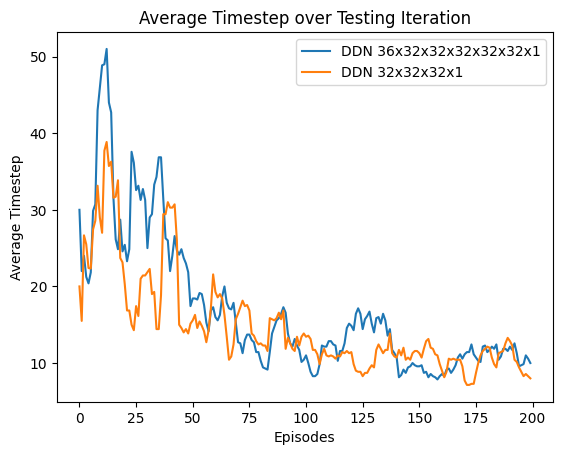

In [ ]:
window_sized = 7

smoothed_timestep_test = moving_average(time_steps_history_test, window_sized)
smoothed_timestep_test2 = moving_average(time_steps_history_test2, window_sized)

# Plot the comparison
plt.plot(smoothed_timestep_test, label='DDN 36x32x32x32x32x32x1')
plt.plot(smoothed_timestep_test2, label='DDN 32x32x32x1')
plt.xlabel('Episodes')
plt.ylabel('Average Timestep')
plt.title('Average Timestep over Testing Iteration')
plt.legend()
plt.show()